In [1]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import sys
sys.path.append(r'C:\Users\yuhan\nanospheres\src')
from utils import load_timestreams, get_psd
from get_sphere_charge import peak_func, fit_peak

In [2]:
from cycler import cycler
colors=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004']
default_cycler = cycler(color=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004'])

params = {'figure.figsize': (7, 3),
          'axes.prop_cycle': default_cycler,
          'axes.titlesize': 14,
          'legend.fontsize': 12,
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)

In [6]:
def calc_geometric_factor(na):
    thetamax = np.arcsin(na)
    C = 2 * ( 8 / 15 - (np.cos(thetamax)**(3/2) ) / 3 - (np.cos(thetamax)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax)**(5/2) ) / 5 - (np.cos(thetamax)**(7/2) ) / 7 )
    return D / C

In [9]:
def get_imprecision_forward_z(p_sca, na_tl, na_cl):
    thetamax_tl = np.arcsin(na_tl)
    thetamax_cl = np.arcsin(na_cl)
    
    A = calc_geometric_factor(na_tl)  # Geometrical factor for z
    C = 2 * ( 8 / 15 - (np.cos(thetamax_cl)**(3/2) ) / 3 - (np.cos(thetamax_cl)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax_cl)**(5/2) ) / 5 - (np.cos(thetamax_cl)**(7/2) ) / 7 )
    B_fw_z = (np.pi / 4) * (D - A * C)

    # Use Eq. (D8)  of PRA 100, 04821 (2019)
    s_zz_imp = (hbar*c / (k * p_sca)) * (np.pi * na**2 / (48 * B_fw_z**2))
    return s_zz_imp

Below first copy some stuff from the noise analysis notebook

### Estimate power scattered by the sphere

First figure out the total scattered power at the trap focus. Use Equation (2.10b) in Vijay Jain's thesis
$$
    \Omega_z = \frac{24}{\pi c \rho} (\frac{\epsilon - 1}{\epsilon +2}) (\frac{\pi \mathrm{NA}}{\lambda})^4   
    \mathrm{NA}^2 P_0,
$$
where $\rho = 2200$ kg/m$^3$, $\epsilon = (1.45)^2$.
Also assume the Rayleigh range for a strongly focus beam is 2.6 times larger (this is the case for NA=0.8 but NA=0.77 should be similar) so scale $\Omega_z \rightarrow \Omega_z / (2.6)^2$.

In [4]:
hbar = 1.055e-34 # (J / Hz) = (kg * m^2 / s)
c = 3e8
rho = 2000
epsilon = 1.45**2
na = 0.77
lambd = 1064e-9
k = 2 * np.pi / lambd
omega_rayleigh= 2.6 * lambd / (np.pi * na**2)  # 2.6 is a correction to paraxial

p0 = 140e-3
omegaz = np.sqrt(24/(np.pi * c * rho) * (epsilon-1)/(epsilon+2) * (np.pi * na / lambd)**4 * na**2 * p0) / (2.6**2)

print(fr'Power at focus = {p0*1000} mW, predicted z frequency : (2 pi) {omegaz / 2 / np.pi / 1000:.2f} kHz')

Power at focus = 140.0 mW, predicted z frequency : (2 pi) 64.86 kHz


Power scattered by the sphere is given by Eq. (2.24)
$$
    P_{\mathrm{sca}} = \frac{1}{3} \frac{k^4 \alpha^2_0}{\pi^2 \epsilon^2_0} \cdot \frac{1}{\omega^2_0} P_0,
$$
where $\alpha_0 = 3 \epsilon_0 V (\epsilon - 1)/(\epsilon + 2)$ is the polarizability ($V$ is the volume of the sphere). 

In [5]:
v = (4/3) * np.pi * (166e-9/2)**3
p_sca = (1/3) * (k**4 * v**2 * ((epsilon-1)/(epsilon+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * p0
print(f'Power scattered by the sphere = {p_sca * 1e6:2f} uW')

Power scattered by the sphere = 1.079937 uW


### Backaction noise

In [7]:
A = calc_geometric_factor(na)
S_ff_z_ba = (A**2 + 2/5) * (hbar * k / c) * p_sca       # Backaction force spectrum
S_f_z_ba = 2 * S_ff_z_ba

print(f'Estimated (single sided) backaction force noise: {S_f_z_ba:.2e} N^2/Hz')

Estimated (single sided) backaction force noise: 4.90e-42 N^2/Hz


### Imprecision noise

In [8]:
S_zz_imp_perfect = (1 / (2/5 + A**2)) * (hbar * c / (4 * k)) / p_sca  # Imprecision assume no information loss
print(f'Estimated (double sided) imprecision noise: {S_zz_imp_perfect:.2e} m^2/Hz assume no information loss')

Estimated (double sided) imprecision noise: 1.14e-27 m^2/Hz assume no information loss


Now estimate the information collection efficiency for NA=0.5 forward scattering lens then attenuated by a factor of 0.0014.

C:\Users\yuhan\AppData\Local\Temp\ipykernel_5504\1378138815.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  s_zz_imp = (hbar*c / (k * p_sca)) * (np.pi * na**2 / (48 * B_fw_z**2))


Text(0, 0.5, '$\\eta_{z, \\mathrm{forward}}$')

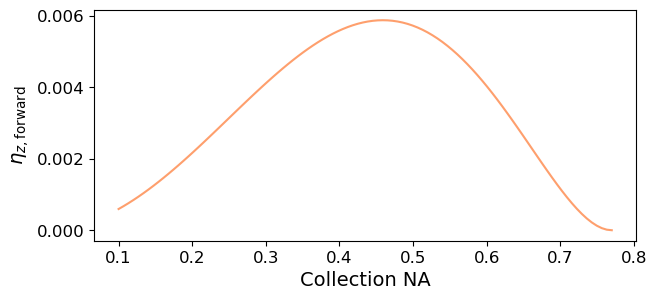

In [10]:
nas = np.linspace(0.1, 0.77, 100)
imp_z_forward = np.empty(nas.size)

for i, na in enumerate(nas):
    imp_z_forward[i] = get_imprecision_forward_z(p_sca, 0.77, na)

plt.plot(nas, S_zz_imp_perfect/imp_z_forward)
plt.xlabel('Collection NA')
plt.ylabel(r'$\eta_{z, \mathrm{forward}}$')

In [11]:
# Because we only use 0.0014 of the actual scattered photon
# so simply scale by that factor
S_zz_imp_actual = get_imprecision_forward_z(p_sca, na_tl=0.77, na_cl=0.7) / 0.0014
S_z_imp_actual = 2 * S_zz_imp_actual

print(f'Estimated (single sided) imprecision noise: {S_z_imp_actual:.2e} m^2/Hz assume NA=0.5 collection and attenuation by a factor of 0.0014')

Estimated (single sided) imprecision noise: 1.69e-21 m^2/Hz assume NA=0.5 collection and attenuation by a factor of 0.0014
